In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import os
#os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder

# Requirements

In [2]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2
import tensorflow_addons as tfa

In [3]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [4]:
from mnist1d_utils import *

# Dataset

In [5]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

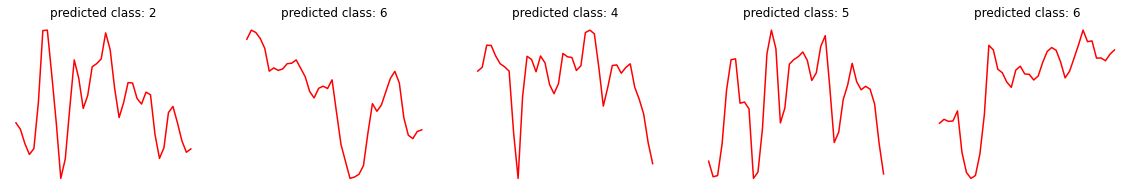

In [6]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

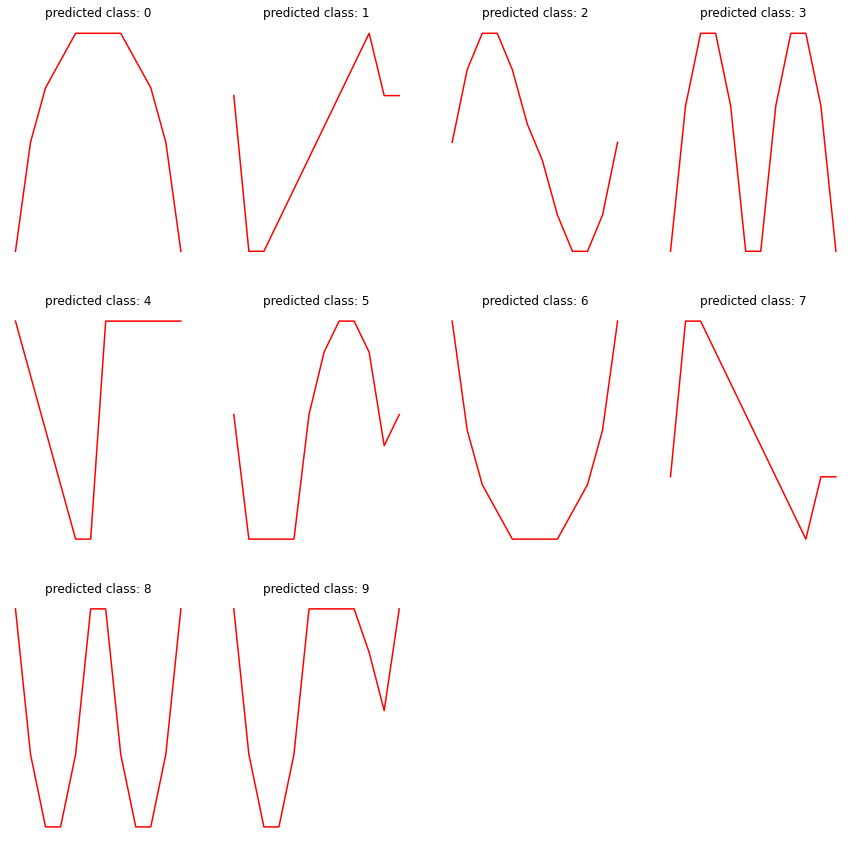

In [7]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(15,15))

plt.subplot(3,4,1)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(3,4,2)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(3,4,3)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(3,4,4)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(3,4,5)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(3,4,6)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(3,4,7)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(3,4,8)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(3,4,9)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(3,4,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [ ]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

In [2]:
from tensorflow.keras import layers

with open (r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\MNIST1D.pkl', 'rb') as fp:
    dataset = pickle.load(fp)

train_data = dataset['x']
train_labels = dataset['y']
test_data = dataset['x_test']
test_labels = dataset['y_test']
spatial_map = dataset['t']
templates = dataset['templates']

train_data.shape = (4000,40,1)

In [3]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here
batch_size = 32 
model.add(layers.Conv1D(25,5,strides=1,padding='same',activation='relu',input_shape=(40,1)))
model.add(layers.Conv1D(25,3,strides=1,padding='same',activation='relu'))
model.add(layers.Conv1D(25,3,strides=1,padding='same',activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation='softmax'))

##

#model.summary()

# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [4]:
##Task1-Question2

#Your code 

optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.01)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

##

# Plotting the training progress

In [18]:
##Task1-Question3.a

#Your code

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True)

model.fit(x=train_data, y=train_labels,
          batch_size=batch_size, 
          epochs=200, 
          validation_split=0, 
          callbacks=[tensorboard_callback])

##

Epoch 1/200
125/125 [==============================] - 1s 4ms/step - loss: 2.2796 - accuracy: 0.0988
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 2.1937 - accuracy: 0.1367
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 2.1016 - accuracy: 0.1988
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 1.9659 - accuracy: 0.2380
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 1.7943 - accuracy: 0.2755
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 1.6813 - accuracy: 0.3243
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 1.6017 - accuracy: 0.3580
Epoch 8/200
125/125 [==============================] - 0s 3ms/step - loss: 1.5333 - accuracy: 0.3920
Epoch 9/200
125/125 [==============================] - 0s 3ms/step - loss: 1.4857 - accuracy: 0.4157
Epoch 10/200
125/125 [==============================] - 0s 3ms/step - loss: 1.4470 - accura

In [19]:
model.save(r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\models\MNIST1D-2.h5')

In [5]:
model = load_model(r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\models\MNIST1D-2.h5')

In [20]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
path = r'D:\Github Repos\ECE1512\-ECE1512_2022W_ProjectRepo_StephanieDiNunzio\Project A\Project_A_Supp\logs\fit\20220301-044101\train\events.out.tfevents.1646127661.DESKTOP-RHIBEOH.46240.2.v2'
for e in my_summary_iterator(path):
  for v in e.summary.value:   
    if v.tag == 'epoch_accuracy':
      train_acc.append(tensorflow.make_ndarray(v.tensor))
    elif v.tag == 'epoch_loss':
      train_loss.append(tensorflow.make_ndarray(v.tensor))


Text(0.5, 1.0, 'Training progress: Accuracy')

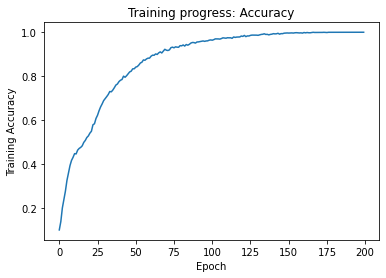

In [21]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

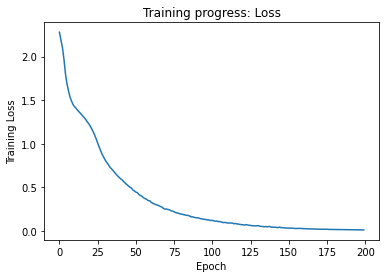

In [22]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

In [7]:
# B Test Accuracy

test_data.shape = (1000,40,1)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=batch_size)
print("test loss, test acc:", results)


Evaluate on test data
32/32 [==============================] - 2s 2ms/step - loss: 0.4633 - accuracy: 0.8870
test loss, test acc: [0.46328654885292053, 0.8870000243186951]


In [24]:
# C Class-wise accuracy
class_data = [[] for _ in range(10)]
for i, data in enumerate(test_data):
    class_data[test_labels[i]].append(data)

for i, data in enumerate(class_data):
    class_data[i] = np.array(data)

class_acc = []

for i in range(10):
    labels = np.array([i] * len(class_data[i]))
    results = model.evaluate(class_data[i], labels, batch_size=batch_size)
    class_acc.append(results[1])
class_acc


4/4 [==============================] - 0s 2ms/step - loss: 1.2528 - accuracy: 0.6569


[0.9803921580314636,
 0.9134615659713745,
 0.8651685118675232,
 0.9716981053352356,
 0.8584905862808228,
 0.8571428656578064,
 0.9494949579238892,
 0.875,
 0.9387755393981934,
 0.656862735748291]

In [25]:
# D ROC and AUC curves for each class

from sklearn import metrics

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    labels = np.zeros(1000)
    for k, label in enumerate(test_labels):
        if label == i:
            labels[k] = 1
    pred = model.predict(test_data, batch_size=batch_size)
    pred_score = np.zeros(1000)
    for j,score in enumerate(pred):
        pred_score[j] = score[i]
    fpr[i], tpr[i], _ = metrics.roc_curve(labels, np.array(pred_score))
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])


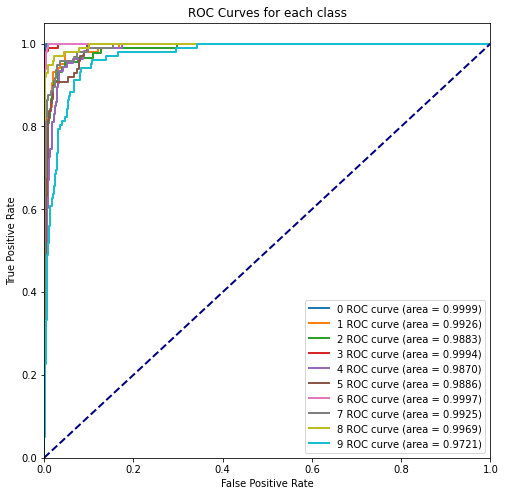

In [26]:
plt.figure(figsize=(8,8))
lw = 2
for i in range(10):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="%d ROC curve (area = %0.4f)" % (i, roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for each class")
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Normalized Confusion Matrix')

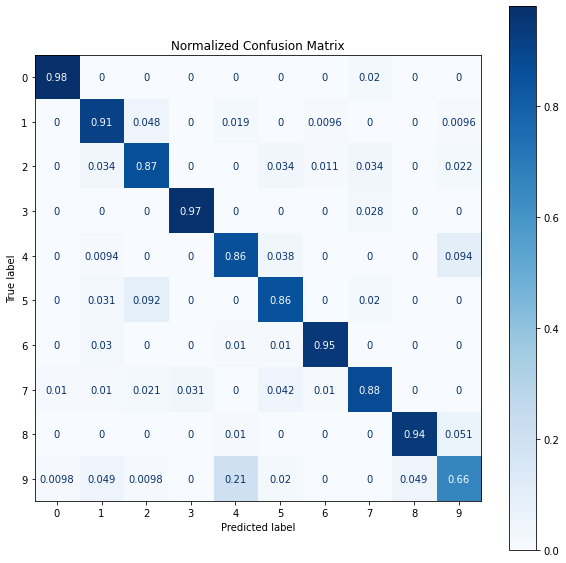

In [27]:
# E Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
pred = model.predict(test_data, batch_size=batch_size)
pred_classes = np.argmax(pred,axis=-1)

title = "Normalized Confusion Matrix"

class_names = list(range(0,10))

fig, ax = plt.subplots(figsize=(10,10))

disp = ConfusionMatrixDisplay.from_predictions(
        test_labels,
        pred_classes,
        display_labels=class_names,
        cmap=plt.cm.Blues, ax=ax,
        normalize='true',
    )
disp.ax_.set_title(title)


In [28]:
# F Precision, Recall, and F-1
from sklearn.metrics import classification_report
report = classification_report(test_labels,pred_classes,output_dict=True)
df = pd.DataFrame(report).transpose()
df.pop('support')
df = pd.concat([df[0:10] , df[12:]])
df

,precision,recall,f1-score
0,0.980392,0.980392,0.980392
1,0.855856,0.913462,0.883721
2,0.819149,0.865169,0.841530
3,0.971698,0.971698,0.971698
4,0.784483,0.858491,0.819820
5,0.857143,0.857143,0.857143
6,0.969072,0.949495,0.959184
7,0.893617,0.875000,0.884211
8,0.948454,0.938776,0.943590
9,0.788235,0.656863,0.716578


In [142]:
# Question 4 Examples of success/failure



In [29]:
# Question 4 Examples of success/failure

success_idx = []
fail_idx = []

for i in range(len(test_labels)):
    if test_labels[i] == pred_classes[i]:
        success_idx.append(i)
    else:
        fail_idx.append(i)


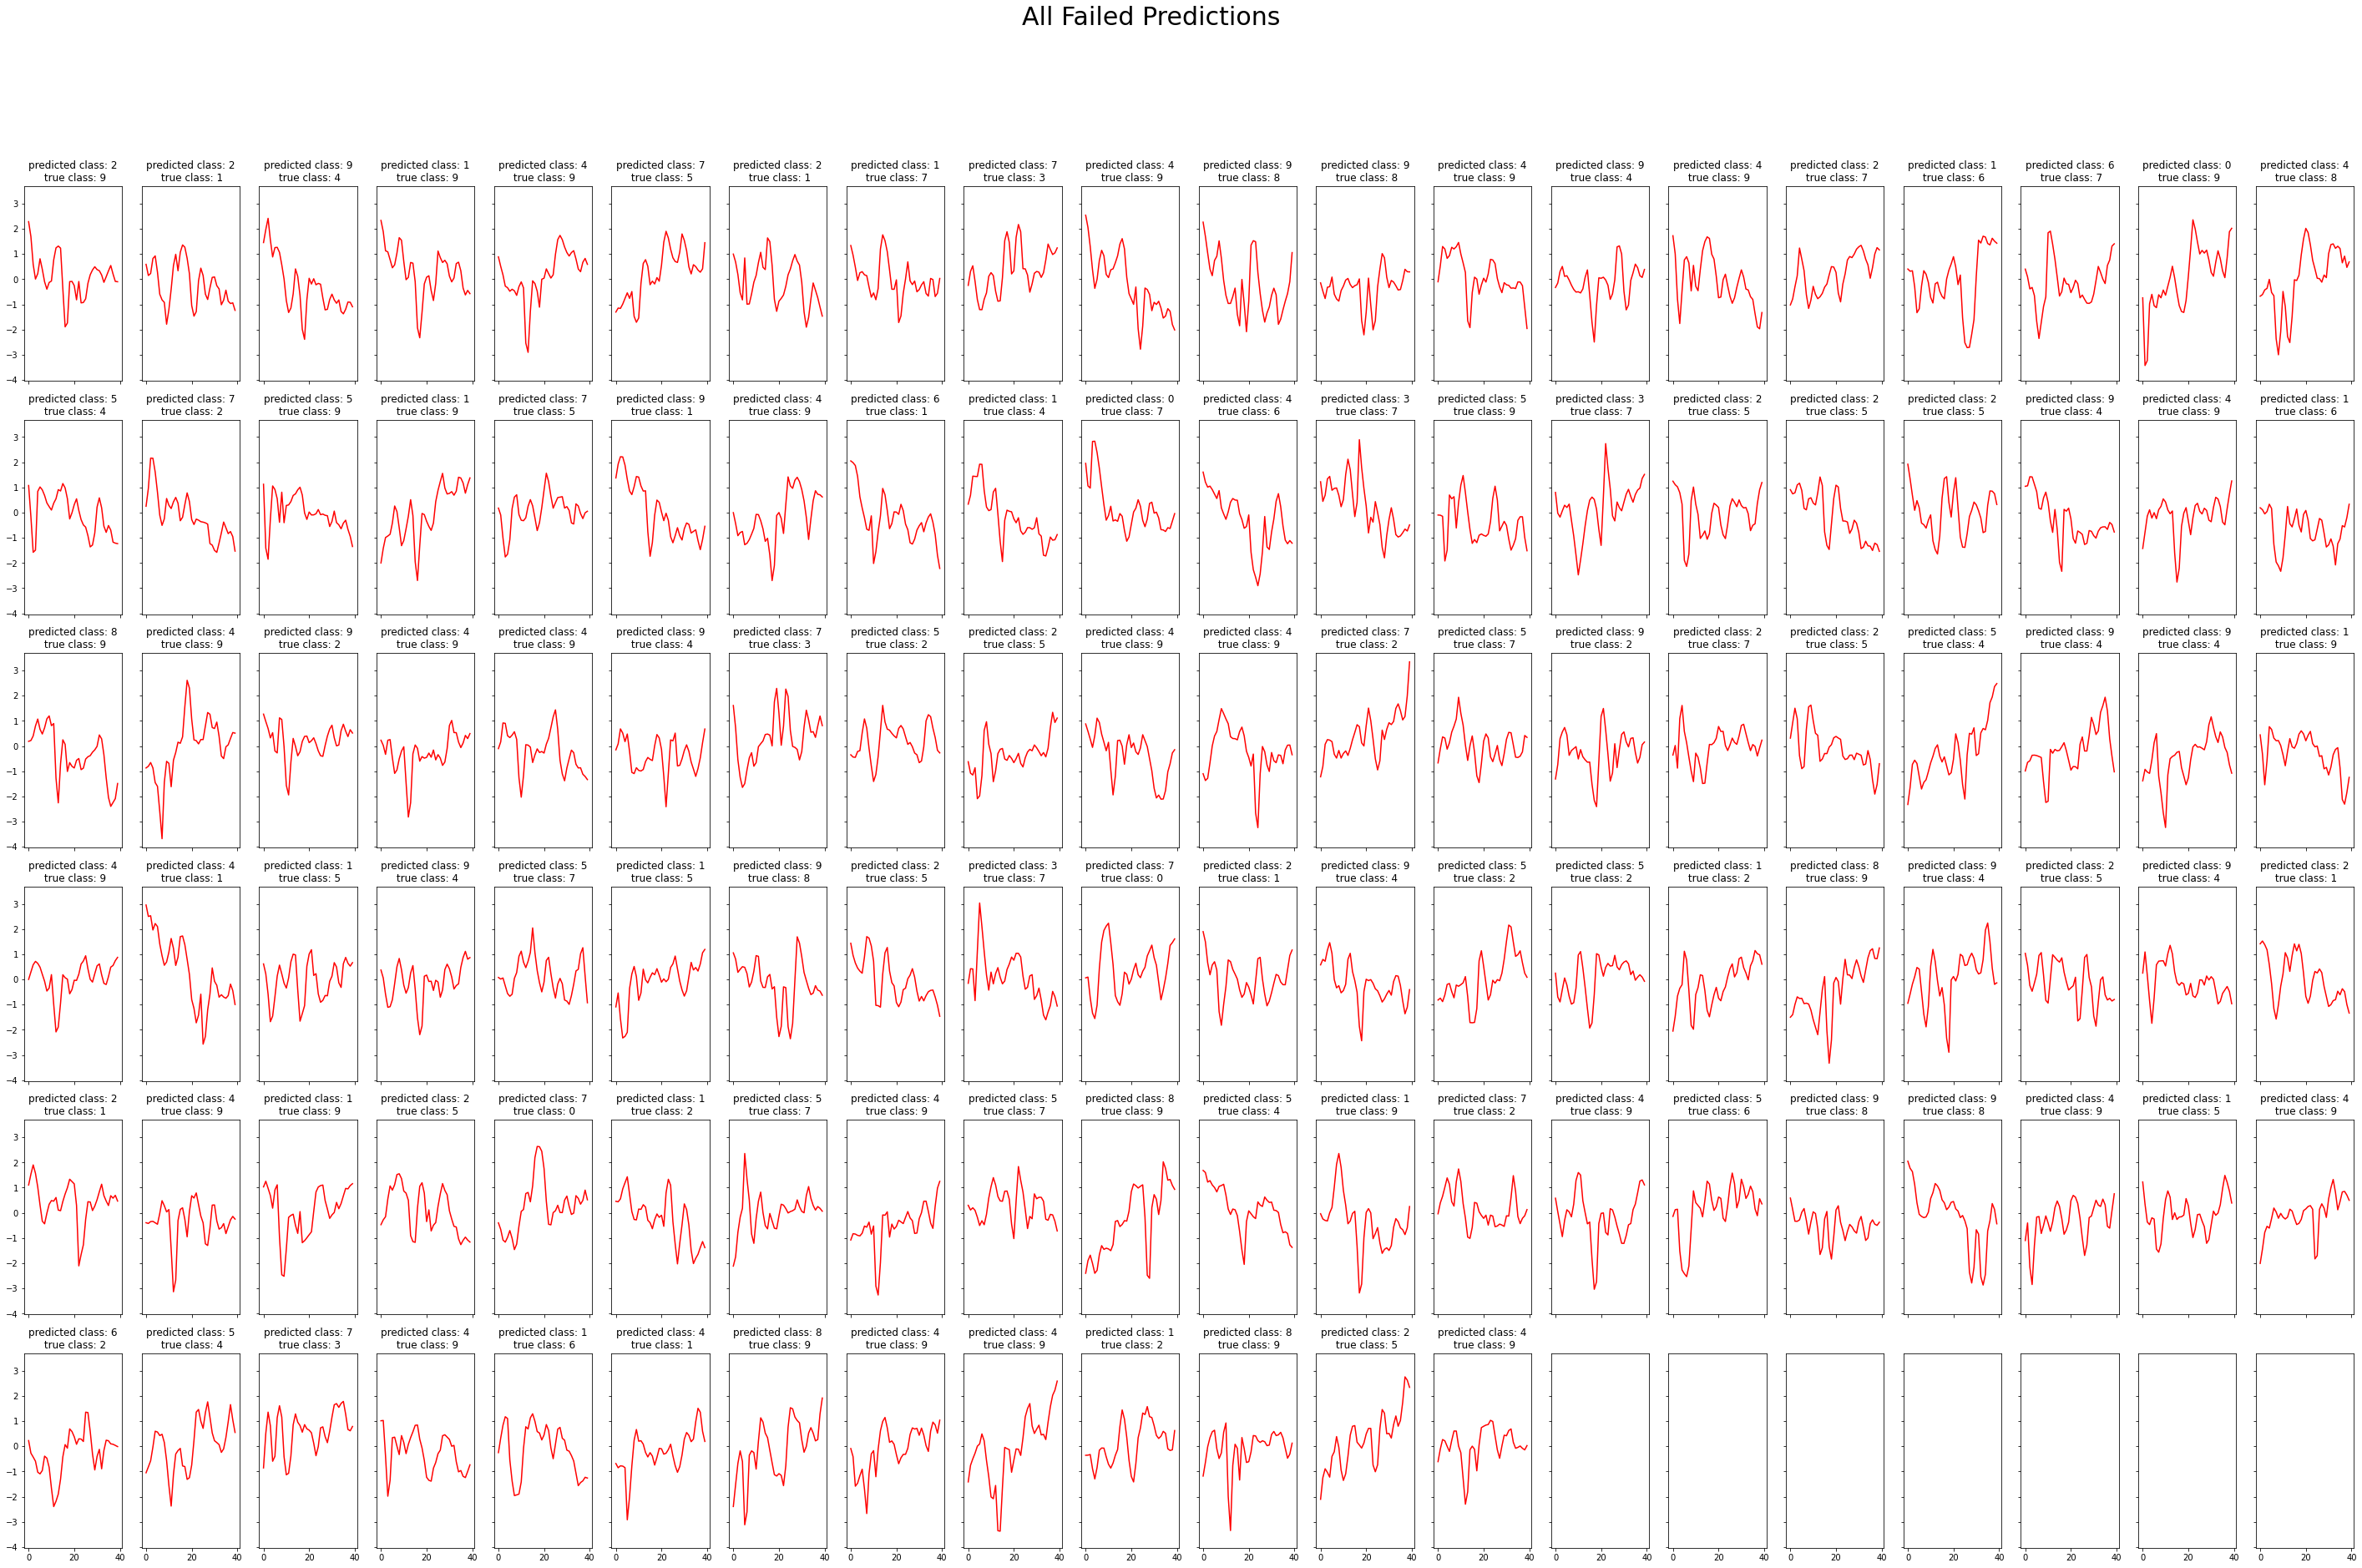

In [30]:
fig, axes = plt.subplots(nrows=6, ncols=20, figsize=(50,30), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i < len(fail_idx):
        ax.plot(test_data[fail_idx[i]], 'r')
        ax.set_title('predicted class: '+str(pred_classes[fail_idx[i]]) + '\n true class: ' +str(test_labels[fail_idx[i]]) )
fig.suptitle('All Failed Predictions', fontsize=30)
plt.show()

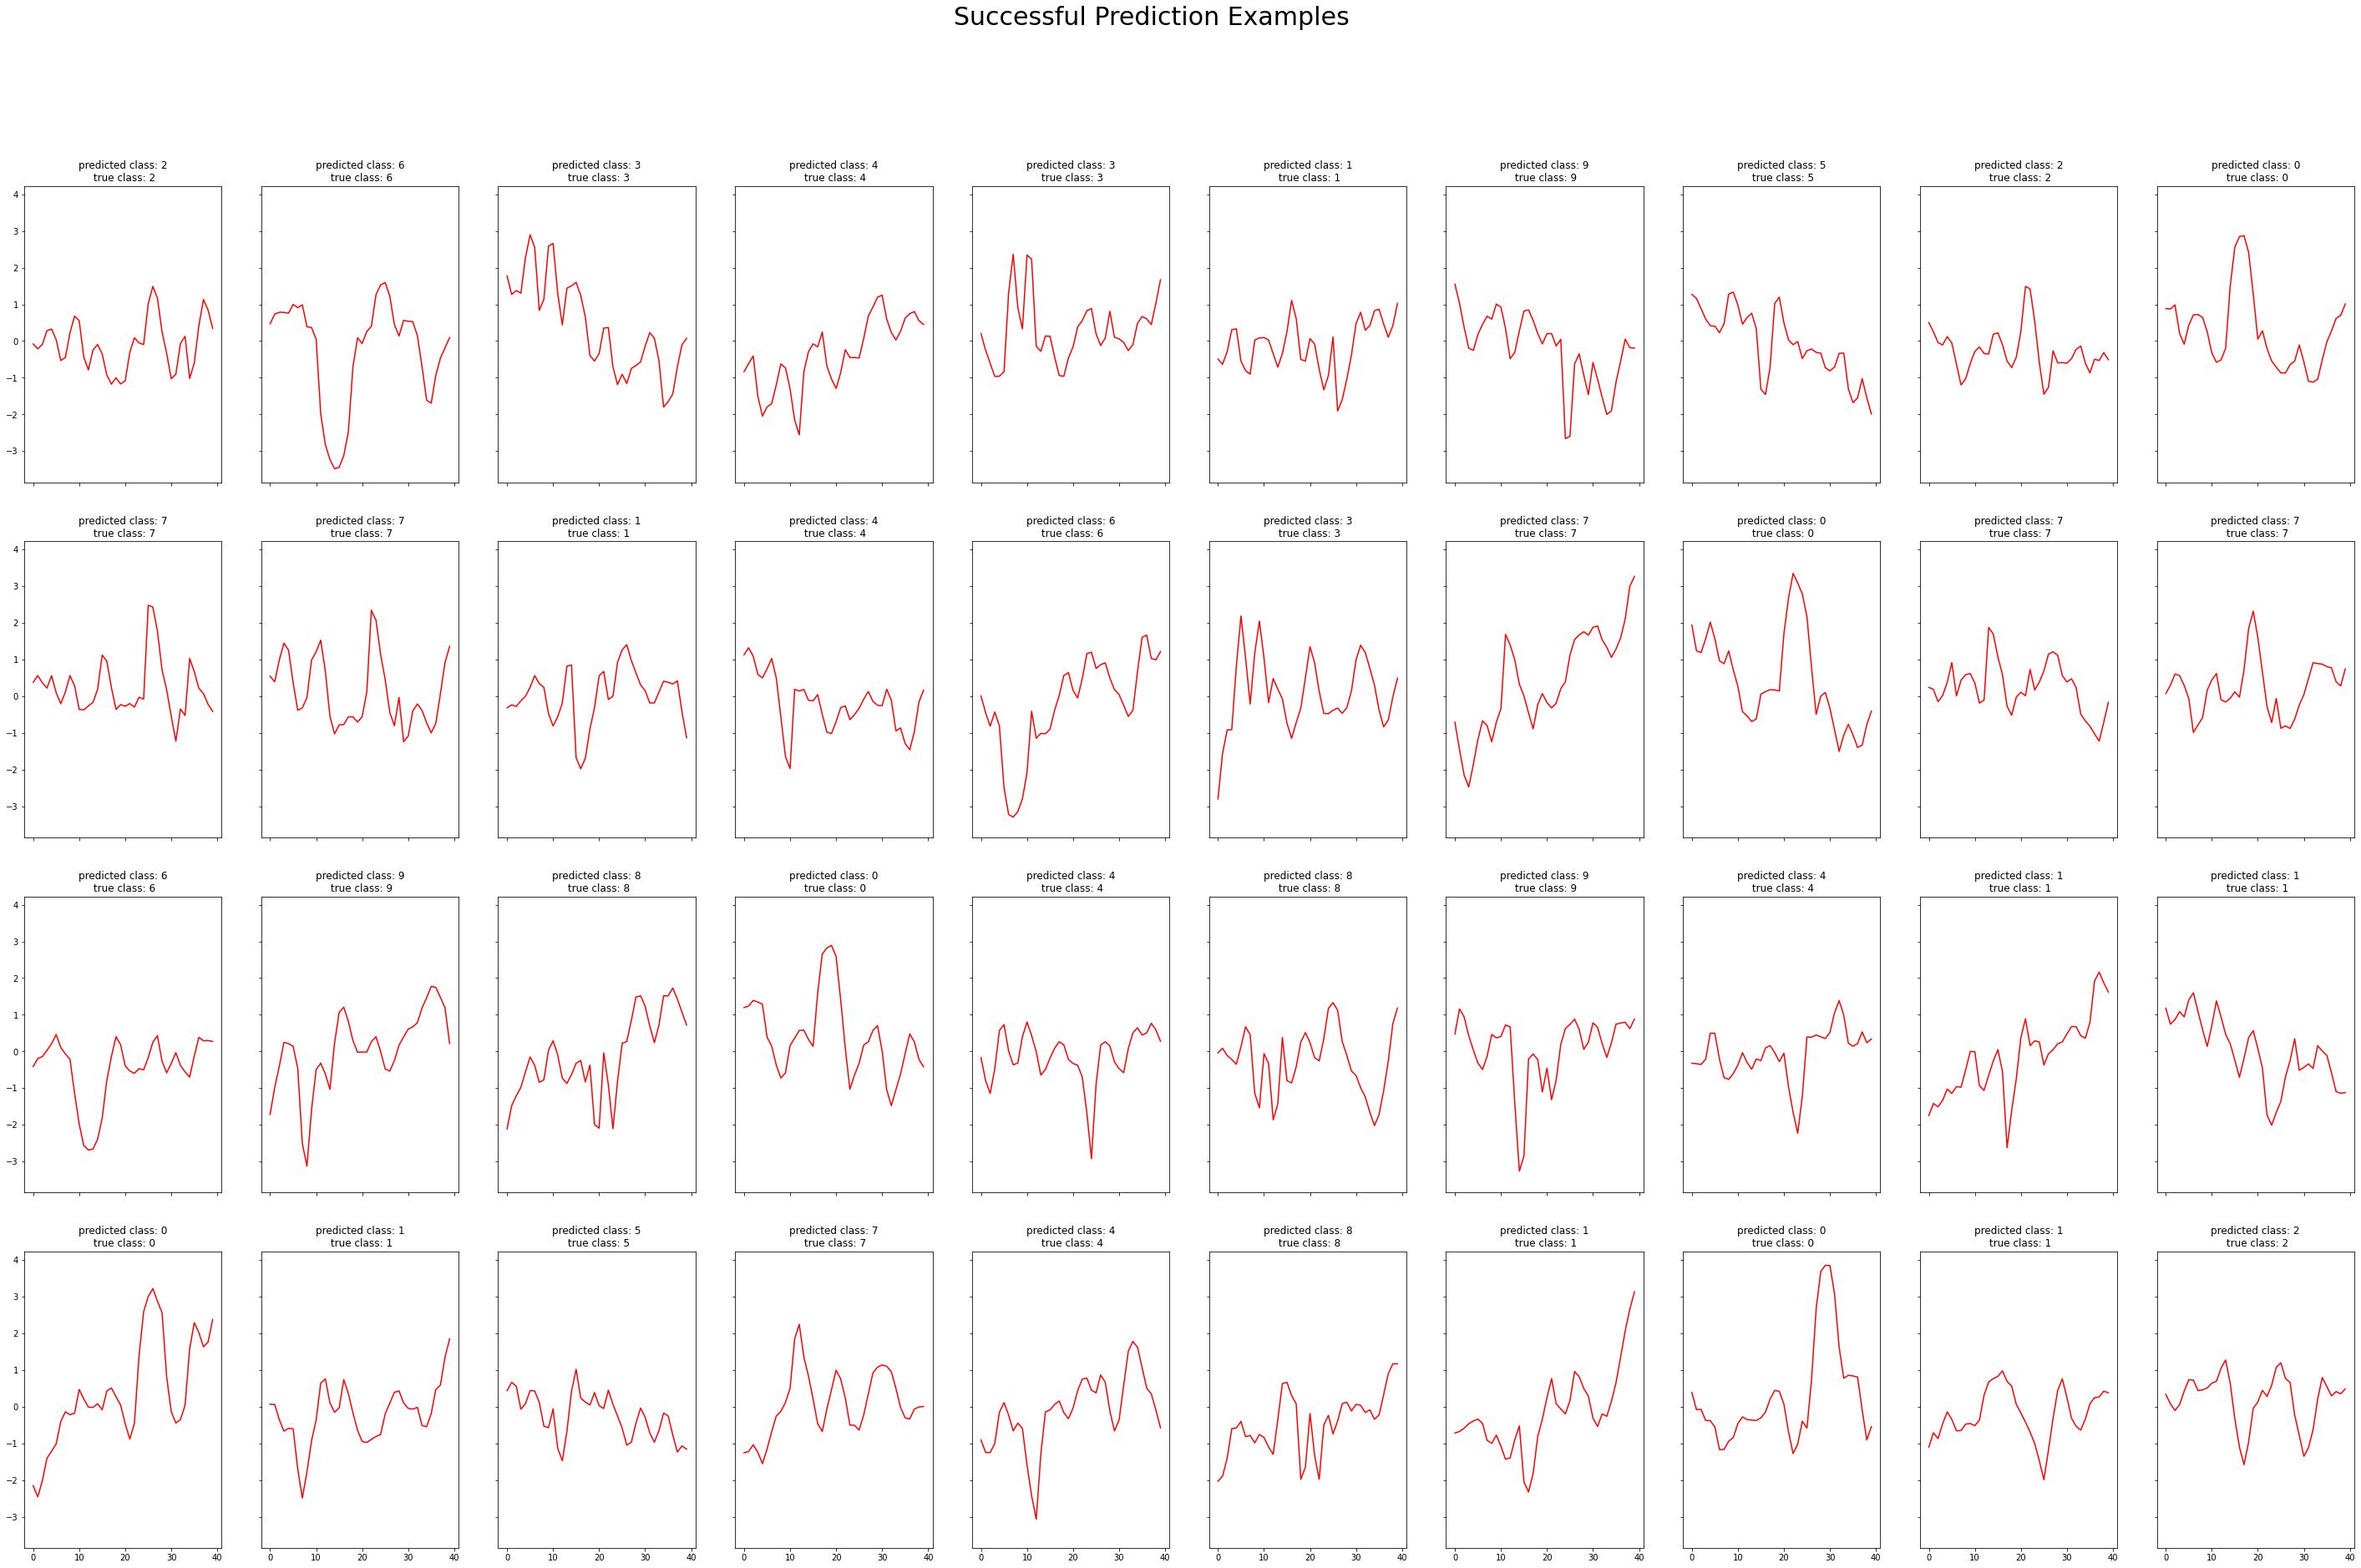

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(50,30), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(test_data[success_idx[i]], 'r')
    ax.set_title('predicted class: '+str(pred_classes[success_idx[i]]) + '\n true class: ' +str(test_labels[success_idx[i]]) )
fig.suptitle('Successful Prediction Examples', fontsize=30)
plt.show()

In [ ]:
# plt.figure(figsize=(20,8))
# j = 1

# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,12))
# for i, ax in enumerate(axes.flatten()):

#     j *= -1
#     if j > 0 :
#         ax.plot(test_data[success_idx[i]], 'r')
#         ax.set_title('predicted class: '+str(pred_classes[i]) + '\n true class: ' +str(test_labels[success_idx[i]]) )
#     else:
#         ax.plot(test_data[fail_idx[i]], 'r')
#         ax.set_title('predicted class: '+str(pred_classes[i]) + '\n true class: ' +str(test_labels[fail_idx[i]]) )
# plt.show()

# Explanation

In [6]:
from xai_utils import *

Take a test sample

In [7]:
x_test = dataset['x_test']
y_test = dataset['y_test']
x_test.shape = (1000,40)
print(x_test.shape)

(1000, 40)


Give the input to the model (Prediction)

In [8]:
index = int(np.floor(np.random.rand()*1000))
#index = 462
#index = 972
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 0
Predicted digit: 0
Confidence score for the correct label: 1.0


In [66]:
print(index)

972


## SISE (Semantic Input Sampling for Explanation)

In [9]:
explanation = SISE(input, model, label, [['conv1d_11']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

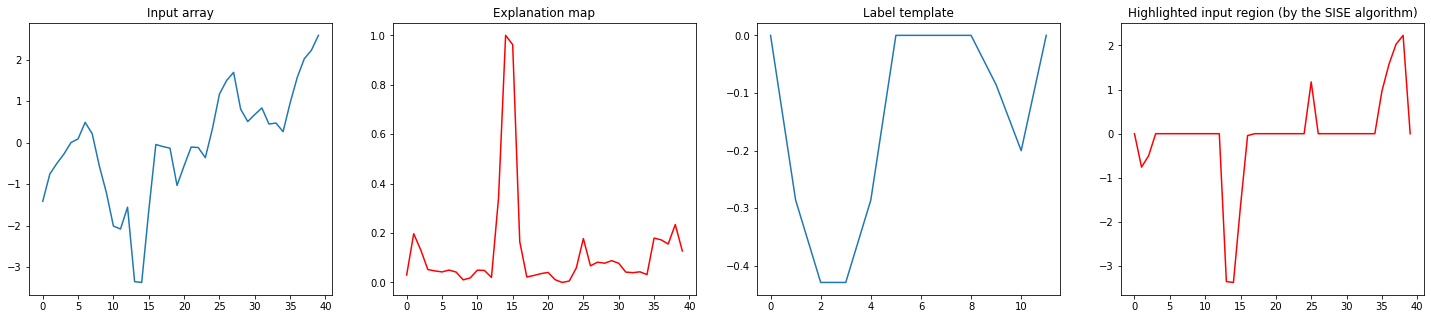

In [68]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## LIME

In [14]:
from lime import *
c_exp, perturbed_img = LIME_1d(input, model, label, num_perturb=300, sec_size=4, kernel_w=0.4, num_feats=4)

Text(0.5, 1.0, 'Perturbed Array')

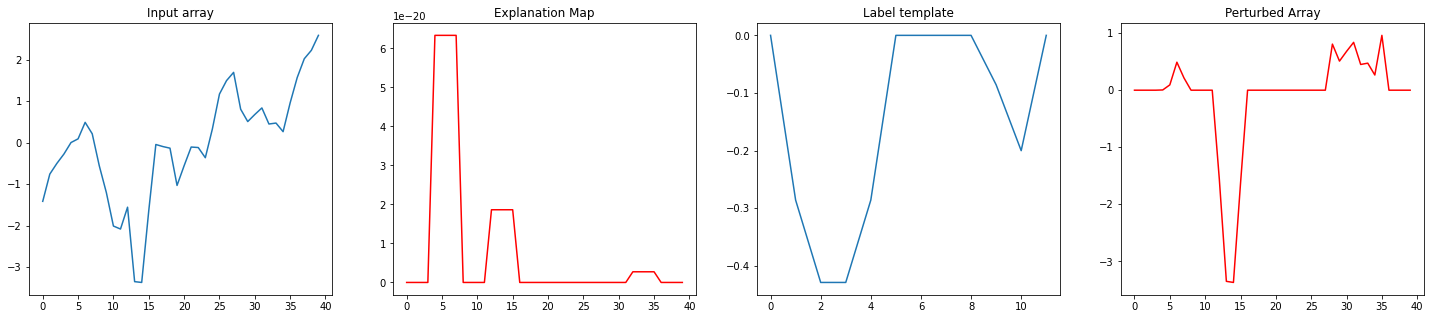

In [70]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(c_exp, 'r')
plt.title('Explanation Map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot(perturbed_img, 'r')
plt.title('Perturbed Array')

## Quantitative evaluation

In [10]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
drop_rate = 0.
increase = 0
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_11']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    drop_rate_add, increase_add = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0:2]
    drop_rate += drop_rate_add
    increase += increase_add
drop_rate /= 1000
increase /=1000

In [17]:
print(drop_rate)
print(increase)
print(explanation_map.shape)


0.2014582926965873
0.343
(40, 1)


In [19]:
drop_rate = 0.
increase = 0
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = LIME_1d(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, np.argmax(prediction[0]), num_perturb=300, sec_size=4, kernel_w=0.4, num_feats=4 )[0]
    explanation_map.shape = (40,1)
    drop_rate_add, increase_add = calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0:2]
    drop_rate += drop_rate_add
    increase += increase_add
drop_rate /= 1000
increase /=1000

In [20]:
print(drop_rate)
print(increase)

0.7610442225030097
0.06
